In [2]:
%%writefile base_agent.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col

def agent(obs_dict, config_dict):
    """This agent always moves toward observation.food[0] but does not take advantage of board wrapping"""
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)
    food = observation.food[0]
    food_row, food_column = row_col(food, configuration.columns)

    if food_row > player_row:
        return Action.SOUTH.name
    if food_row < player_row:
        return Action.NORTH.name
    if food_column > player_column:
        return Action.EAST.name
    return Action.WEST.name



Writing base_agent.py


In [40]:
%%writefile test1.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col

def agent(obs_dict, config_dict):
    """This agent always moves toward observation.food[0] but does not take advantage of board wrapping"""
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)
    food = observation.food[0]
    food_row, food_column = row_col(food, configuration.columns)

    if player_column % 2 == 0:
        return Action.WEST.name
    if player_column % 2 == 1:
        return Action.EAST.name
    return Action.WEST.name

Overwriting test1.py


In [2]:
%%writefile greedy.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
from random import choice, sample

def random_agent():
    return choice([action for action in Action]).name


def translate(position: int, direction: Action, columns: int, rows: int):
    row, column = row_col(position, columns)
    row_offset, column_offset = direction.to_row_col()
    row = (row + row_offset) % rows
    column = (column + column_offset) % columns
    return row * columns + column


def adjacent_positions(position: int, columns: int, rows: int):
    return [
        translate(position, action, columns, rows)
        for action in Action
    ]


def min_distance(position: int, food: [int], columns: int):
    row, column = row_col(position, columns)
    return min(
        abs(row - food_row) + abs(column - food_column)
        for food_position in food
        for food_row, food_column in [row_col(food_position, columns)]
    )


def agent(observation, configuration):
    observation = Observation(observation)
    configuration = Configuration(configuration)
    rows, columns = configuration.rows, configuration.columns

    food = observation.food
    geese = observation.geese
    opponents = [
        goose
        for index, goose in enumerate(geese)
        if index != observation.index and len(goose) > 0
    ]

    # Don't move adjacent to any heads
    head_adjacent_positions = {
        opponent_head_adjacent
        for opponent in opponents
        for opponent_head in [opponent[0]]
        for opponent_head_adjacent in adjacent_positions(opponent_head, rows, columns)
    }
    # Don't move into any bodies
    bodies = {position for goose in geese for position in goose[0:-1]}
    # Don't move into tails of heads that are adjacent to food
    tails = {
        opponent[-1]
        for opponent in opponents
        for opponent_head in [opponent[0]]
        if any(
            adjacent_position in food
            # Head of opponent is adjacent to food so tail is not safe
            for adjacent_position in adjacent_positions(opponent_head, rows, columns)
        )
    }

    # Move to the closest food
    position = geese[observation.index][0]
    actions = {
        action: min_distance(new_position, food, columns)
        for action in Action
        for new_position in [translate(position, action, columns, rows)]
        if (
            new_position not in head_adjacent_positions and
            new_position not in bodies and
            new_position not in tails
        )
    }

    if any(actions):
        return min(actions, key=actions.get).name

    return random_agent()

Writing greedy.py


In [141]:
%%writefile risk_averse_greedy.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
import numpy as np

last_action = 0

def get_nearest_cells(x,y):
    # returns all cells reachable from the current one
    result = []
    for i in (-1,+1):
        result.append(((x+i+7)%7, y))
        result.append((x, (y+i+11)%11))
    return result

def find_closest_food(table):
    
    global last_action
    
    # returns the first step toward the closest food item
    new_table = table.copy()
    
    updated = False
    for roll, axis, code in [
        (1, 0, 1),
        (-1, 0, 2),
        (1, 1, 3),
        (-1, 1, 4)
    ]:

        if last_action == 1:
            if code == 2:
                continue
        if last_action == 2:
            if code == 1:
                continue
        if last_action == 3:
            if code == 4:
                continue
        if last_action == 4:
            if code == 3:
                continue
        
        shifted_table = np.roll(table, roll, axis)
        
        if (table == -2).any() and (shifted_table[table == -2] == -3).any(): # we have found some food at the first step
            return code
        else:
            mask = np.logical_and(new_table == 0,shifted_table == -3)
            if mask.sum() > 0:
                updated = True
            new_table += code * mask
        if (table == -2).any() and shifted_table[table == -2][0] > 0: # we have found some food
            return shifted_table[table == -2][0]
        
        # else - update new reachible cells
        mask = np.logical_and(new_table == 0,shifted_table > 0)
        if mask.sum() > 0:
            updated = True
        new_table += shifted_table * mask

    # if we updated anything - continue reccurison
    if updated:
        return find_closest_food(new_table)
    
    # if not - return some step
    else:        
        return not_free_movements(table)
    
    
def not_free_movements(table):
    
    global last_action
    
    for i in (-4,-5):
        for roll, axis, code in [
            (1, 0, 1),
            (-1, 0, 2),
            (1, 1, 3),
            (-1, 1, 4)
        ]:

            if last_action == 1:
                if code == 2:
                    continue
            elif last_action == 2:
                if code == 1:
                    continue
            elif last_action == 3:
                if code == 4:
                    continue
            elif last_action == 4:
                if code == 3:
                    continue

            shifted_table = np.roll(table, roll, axis)

            if (table == i).any() and (shifted_table[table == i] == -3).any():
                return code
        
        return last_action
    

def agent(obs_dict, config_dict):
    """This agent always moves toward observation.food[0] but does not take advantage of board wrapping"""
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)
    
    global last_action

    table = np.zeros((7,11))
    # 0 - emply cells
    # -1 - obstacles
    # -2 - food
    # -3 - head
    # -4 - food but long
    # -5 - possible opponent's next moves
    # 1,2,3,4 - reachable on the current step cell, number is the id of the first step direction
    
    legend = {
        1: 'SOUTH',
        2: 'NORTH',
        3: 'EAST',
        4: 'WEST'
    }
    
    # -2
    # let's add food to the map
    for food in observation.food:
        x,y = row_col(food, configuration.columns)
        
        # add food to the map if the player geese is short (<4)
        if len(observation.geese[player_index]) < 4:
            table[x,y] = -2 # food
        
        # if the player geese is long (>=4) dont incentive him to eat to be easier to survive
        else:
            table[x,y] = -4
        
        
    # -1
    # let's add all cells that are forbidden
    for i in range(4):
        opp_goose = observation.geese[i]
        if len(opp_goose) == 0:
            continue
        for n in opp_goose[:-1]:
            x,y = row_col(n, configuration.columns)
            table[x,y] = -1 # forbidden cells
        if i != player_index:
            x,y = row_col(opp_goose[0], configuration.columns)
            possible_moves = get_nearest_cells(x,y) # head can move anywhere
            for x,y in possible_moves:
                table[x,y] = -5 # forbidden cells 
       
    # -3
    # let's add head position
    x,y = row_col(player_head, configuration.columns) 
    table[x,y] = -3
    
    # the first step toward the nearest food
    step = int(find_closest_food(table))
    
    # if there is not available steps make random step
    if step not in [1,2,3,4]:
        step = np.random.randint(4) + 1
    
    last_action = step
    
    return legend[step]

Overwriting risk_averse_greedy.py


In [153]:
d = {'a': 3, 'b': 4, 'c': 5}

max(d, key=d.get)

'c'

In [17]:
import numpy as np
AA = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(AA)

table = AA
roll = -1
axis = 1

shifted_table = np.roll(table, roll, axis)
print(shifted_table)

BB = np.array([[1,2,5],[0,0,0],[0,0,0]])

np.logical_and(BB, AA)*2

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[2 3 1]
 [5 6 4]
 [8 9 7]]


array([[2, 2, 2],
       [0, 0, 0],
       [0, 0, 0]])

In [19]:
AA[BB == 5]

array([3])

In [20]:
BB == 5

array([[False, False,  True],
       [False, False, False],
       [False, False, False]])

In [9]:
def find_closest_food(table, i=0):
    # returns the first step toward the closest food item
    print(i)
    print(table)
    
    new_table = table.copy()
    
    updated = False
    for roll, axis, code in [
        (1, 0, 1),
        (-1, 0, 2),
        (1, 1, 3),
        (-1, 1, 4)
    ]:

        shifted_table = np.roll(table, roll, axis)
        
        if (table == -2).any() and (shifted_table[table == -2] == -3).any(): # we have found some food at the first step
            return code
        else:
            mask = np.logical_and(new_table == 0,shifted_table == -3)
            if mask.sum() > 0:
                updated = True
            new_table += code * mask
        if (table == -2).any() and shifted_table[table == -2][0] > 0: # we have found some food
            return shifted_table[table == -2][0]
        
        # else - update new reachible cells
        mask = np.logical_and(new_table == 0,shifted_table > 0)
        if mask.sum() > 0:
            updated = True
        new_table += shifted_table * mask

    # if we updated anything - continue reccurison
    if updated:
        return find_closest_food(new_table, i=i+1)
    # if not - return some step
    else:
        return table.max()

In [ ]:
tableA = np.array(
        [[0,0,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,-3,-1,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,0,0],
         [0,-1,-1,-1,-1,-1,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,-1,0,0],
         [0,0,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,0,0],    
        ])

find_closest_food(tableA)

In [82]:
%%writefile risk_averse_greedy_0.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
import numpy as np

def get_nearest_cells(x,y):
    # returns all cells reachable from the current one
    result = []
    for i in (-1,+1):
        result.append(((x+i+7)%7, y))
        result.append((x, (y+i+11)%11))
    return result

def find_closest_food(table):
    # returns the first step toward the closest food item
    new_table = table.copy()
    
    updated = False
    for roll, axis, code in [
        (1, 0, 1),
        (-1, 0, 2),
        (1, 1, 3),
        (-1, 1, 4)
    ]:

        shifted_table = np.roll(table, roll, axis)
        
        if (table == -2).any() and (shifted_table[table == -2] == -3).any(): # we have found some food at the first step
            return code
        else:
            mask = np.logical_and(new_table == 0,shifted_table == -3)
            if mask.sum() > 0:
                updated = True
            new_table += code * mask
        if (table == -2).any() and shifted_table[table == -2][0] > 0: # we have found some food
            return shifted_table[table == -2][0]
        
        # else - update new reachible cells
        mask = np.logical_and(new_table == 0,shifted_table > 0)
        if mask.sum() > 0:
            updated = True
        new_table += shifted_table * mask

    # if we updated anything - continue reccurison
    if updated:
        return find_closest_food(new_table)
    # if not - return some step
    else:
        return table.max()

def agent(obs_dict, config_dict):
    """This agent always moves toward observation.food[0] but does not take advantage of board wrapping"""
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)


    table = np.zeros((7,11))
    # 0 - emply cells
    # -1 - obstacles
    # -2 - food
    # -3 - head
    # 1,2,3,4 - reachable on the current step cell, number is the id of the first step direction
    
    legend = {
        1: 'SOUTH',
        2: 'NORTH',
        3: 'EAST',
        4: 'WEST'
    }
    
    # let's add food to the map
    for food in observation.food:
        x,y = row_col(food, configuration.columns)
        table[x,y] = -2 # food
        
    # let's add all cells that are forbidden
    for i in range(4):
        opp_goose = observation.geese[i]
        if len(opp_goose) == 0:
            continue
        for n in opp_goose[:-1]:
            x,y = row_col(n, configuration.columns)
            table[x,y] = -1 # forbidden cells
        if i != player_index:
            x,y = row_col(opp_goose[0], configuration.columns)
            possible_moves = get_nearest_cells(x,y) # head can move anywhere
            for x,y in possible_moves:
                table[x,y] = -1 # forbidden cells

        
    # let's add head position
    x,y = row_col(player_head, configuration.columns)
    table[x,y] = -3
    
    # the first step toward the nearest food
    step = int(find_closest_food(table))
    
    # if there is not available steps make random step
    if step not in [1,2,3,4]:
        step = np.random.randint(4) + 1
    
    return legend[step]

Writing risk_averse_greedy_0.py


In [ ]:
%%writefile enrico_agent.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col, translate, adjacent_positions
import numpy as np

last_action = None

def min_dist(position, food, columns, rows):
    row, column = row_col(position, columns)
    return min(
        min(abs(row - food_row), (abs(row - food_row)-rows)) + min(abs(column - food_column), (abs(column - food_column)-columns))
        for food_position in food
        for food_row, food_column in [row_col(food_position, columns)]
    )
        
def score(next_position, food, columns, rows, bodies, self_len):
    
    body_collision = next_position in bodies
    danger_move = next_position in head_adjacent_positions
    food_dist = min_dist(next_position, food, columns, rows) if (self_len < 4) else 15
    
    score = (15-food_dist) + (body_collision*(-1e6)) + (danger_move*(-1e4))
    return score    
        

def my_agent(obs, config):

        rows, columns = config.rows, config.columns

        food = obs.food
        geese = obs.geese
        opponents = [
            goose
            for index, goose in enumerate(geese)
            if index != obs.index and len(goose) > 0
        ]
    
        # Don't move adjacent to any heads
        head_adjacent_positions = {
            opponent_head_adjacent
            for opponent in opponents
            for opponent_head in [opponent[0]]
            for opponent_head_adjacent in adjacent_positions(opponent_head, rows, columns)
        }
        # Don't move into any bodies
        bodies = {position for goose in geese for position in goose}

        
        # Move to the closest food
        position = geese[obs.index][0]
        
        actions = {
            action : score(new_position, food, columns, rows, bodies, len(geese[obs.index]))
            #action: min_dist(new_position, food, columns, rows)
            for action in Action
            for new_position in [translate(position, action, columns, rows)]
            if self.last_action is None or action != self.last_action.opposite()
        }        
        
        action = max(actions, key=actions.get) if any(actions) else choice([action for action in Action if action != self.last_action.opposite()])
        self.last_action = action

        return action.name

In [33]:
%%writefile enrico_agent.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col, translate, adjacent_positions
import numpy as np

bucle = False

def min_food_dist(position, food, columns, rows):
    row, column = row_col(position, columns)
    return min(
        min(abs(row - food_row), (abs(abs(row - food_row)-rows))) + min(abs(column - food_column), (abs(abs(column - food_column)-columns)))
        for food_position in food
        for food_row, food_column in [row_col(food_position, columns)]
    )

def min_tail_dist(position, my_tail, columns, rows):
    row, column = row_col(position, columns)
    tail_row, tail_column = row_col(my_tail, columns)
    return min(abs(row - tail_row), (abs(abs(row - tail_row)-rows))) + min(abs(column - tail_column), (abs(abs(column - tail_column)-columns)))

def opposite(action):
    if action == Action.NORTH:
        return Action.SOUTH
    if action == Action.SOUTH:
        return Action.NORTH
    if action == Action.EAST:
        return Action.WEST
    if action == Action.WEST:
        return Action.EAST
    raise TypeError(str(action) + " is not a valid Action.")
        
        
def score(next_position, food, columns, rows, bodies, self_len, head_adjacent_positions, my_tail, tails, action, opponents, step):
    
    global bucle
    
    if self_len > 4 and step < 100:
        bucle = True
    else:
        bucle = False
    
    if self_len > 8:
        bucle = True
    
    if step > 150:
        if self_len <= max([len(op) for op in opponents]):
            bucle = False
    
    body_collision = next_position in bodies
    danger_move = (next_position in head_adjacent_positions) if (min_tail_dist(next_position, my_tail, columns, rows) > 0) else 0
    food_dist = min_food_dist(next_position, food, columns, rows) if (self_len < 9 or not bucle) else min_tail_dist(next_position, my_tail, columns, rows)
    to_enemy_tail = next_position in tails
    
    if bucle:
        if self_len < 7:
            bucle = False
            
    food_safe = 1
    near_ops = 0
    if (self_len > 4) and not bucle:
        for op in opponents:
            if min_tail_dist(next_position, op[0], columns, rows) < 5:
                near_ops += 1    
        if near_ops > 1:
            food_safe = -1  
            
    way_out = 0
    max_way_out = 0
    for next_action in Action:
        if way_out == 4:
            max_way_out = 4
            break 
        
        if way_out > max_way_out:
            max_way_out = way_out
            
        way_out = 0
        if next_action != opposite(action):   
            next2_position = translate(next_position, next_action, columns, rows)
            if next2_position not in bodies:
                way_out = 1
                if next2_position in head_adjacent_positions:
                    way_out -= 0.5               
                
                    for next2_action in Action: 
                        if way_out == 4:
                            break
                        if next2_action != opposite(next_action):
                            next3_position = translate(next2_position, next2_action, columns, rows)
                            if next3_position not in bodies:
                                way_out += 1
                                if next3_position in head_adjacent_positions:
                                    way_out -= 0.5 

                                    for next3_action in Action:
                                        if way_out == 4:
                                            break
                                        if next3_action != opposite(next2_action):  
                                            next4_position = translate(next3_position, next3_action, columns, rows)
                                            if next4_position not in bodies:
                                                way_out += 1
                                                if next4_position in head_adjacent_positions:
                                                    way_out -= 0.5 

                                                    for next4_action in Action: 
                                                        if next4_action != opposite(next3_action):
                                                            next5_position = translate(next2_position, next2_action, columns, rows)
                                                            if next5_position not in bodies:
                                                                way_out += 1
                                                                if next5_position in head_adjacent_positions:
                                                                    way_out -= 0.5
                                                                break
        
        
    score = (15-(food_dist*food_safe)) + (body_collision*(-1e6+food_dist)) + (max_way_out*1e4) + (2*danger_move*(-1e4+food_dist)) + (to_enemy_tail*(-1e2)) 
    
    return score    
        

class MyAgent:
    def __init__(self, configuration):
        self.configuration = configuration
        self.last_action = None

    def __call__(self, observation):
        rows, columns = self.configuration.rows, self.configuration.columns

        food = observation.food
        geese = observation.geese
        opponents = [
            goose
            for index, goose in enumerate(geese)
            if index != observation.index and len(goose) > 0
        ]
    
        # Don't move adjacent to any heads
        head_adjacent_positions = {
            opponent_head_adjacent
            for opponent in opponents
            for opponent_head_adjacent in adjacent_positions(opponent[0], columns, rows)
        }

        
        # Don't move into any bodies
        
        bodies = []
        for goose in geese:
            if len(goose)==1:
                bodies += [position for position in goose]
            elif len(goose)>1:
                bodies += [position for position in goose[:-1]]
        
        #bodies = {position for goose in geese for position in goose[:-1]} 
        tails = {goose[-1] for goose in opponents if len(goose)>1}

        
        # Move to the closest food
        position = geese[observation.index][0]
        
        actions = {
            action : score(new_position, food, columns, rows, bodies, len(geese[observation.index]), head_adjacent_positions, geese[observation.index][-1], tails, action, opponents, observation.step)
            #action: min_dist(new_position, food, columns, rows)
            for action in Action
            for new_position in [translate(position, action, columns, rows)]
            if (self.last_action is None or action != opposite(self.last_action))
        }  
        
        action = max(actions, key=actions.get) if any(actions) else choice([action for action in Action if (self.last_action is None or action != opposite(self.last_action))])
        self.last_action = action
        
        if(observation.index == 0):    
            print(len(geese[observation.index]), "\n", action.name, "\n", actions, "\n", opposite(action), "\n player: ", geese[observation.index], " head adj: ", head_adjacent_positions)
        
        return action.name


cached_my_agents = {}
        
def my_agent(obs, config):
    index = obs["index"]
    if index not in cached_my_agents:
        cached_my_agents[index] = MyAgent(Configuration(config))
    return cached_my_agents[index](Observation(obs))
        
        

        

Overwriting enrico_agent.py


# Example Using The kaggle_environments For Testing Agents

In [3]:
from kaggle_environments import evaluate, make, utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

Loading environment football failed: No module named 'gfootball'


In [4]:
env = make("hungry_geese", debug=True)

In [34]:
env.reset()
env.run(["enrico_agent.py", "enrico_agent.py", "enrico_agent.py", "enrico_agent.py"])
env.render(mode="ipython", width=300, height=300)

1 
 WEST 
 {<Action.NORTH: 1>: 10013.0, <Action.EAST: 2>: 25011.0, <Action.SOUTH: 3>: -964985.0, <Action.WEST: 4>: 25013.0} 
 Action.EAST 
 player:  [10]  head adj:  {32, 3, 5, 70, 10, 11, 13, 15, 20, 25}
1 
 SOUTH 
 {<Action.NORTH: 1>: 10014.0, <Action.SOUTH: 3>: 25012.0, <Action.WEST: 4>: 10014.0} 
 Action.NORTH 
 player:  [9]  head adj:  {0, 4, 69, 36, 71, 12, 14, 21, 22, 24, 26, 59}
1 
 EAST 
 {<Action.EAST: 2>: 25011.0, <Action.SOUTH: 3>: 10011.0, <Action.WEST: 4>: 10013.0} 
 Action.WEST 
 player:  [20]  head adj:  {1, 3, 68, 37, 70, 11, 13, 15, 23, 25, 58, 27}
1 
 EAST 
 {<Action.NORTH: 1>: 10012.0, <Action.EAST: 2>: 25012.0, <Action.SOUTH: 3>: 10010.0} 
 Action.WEST 
 player:  [21]  head adj:  {2, 4, 69, 12, 14, 16, 24, 26}
1 
 EAST 
 {<Action.NORTH: 1>: 10011.0, <Action.EAST: 2>: 25013.0, <Action.SOUTH: 3>: 25011.0} 
 Action.WEST 
 player:  [11]  head adj:  {3, 35, 5, 70, 13, 15, 17, 23, 25, 27}
1 
 EAST 
 {<Action.NORTH: 1>: 10012.0, <Action.EAST: 2>: 25014.0, <Action.SOUTH: 3

# Comparison in Battle

In [83]:
list_names = [
    "simple_toward", 
    "greedy",
    "risk_averse_greedy",
    "risk_averse_greedy_0",
]
list_agents = [agent_name + ".py" for agent_name in list_names]

n_agents = len(list_names)

scores = np.zeros((n_agents, n_agents), dtype=np.int)

In [247]:
print("Simulation of battles. It can take some time...")

for ind_agent_1 in range(len(list_names)):
    for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
        print(
            f"LOG: {list_names[ind_agent_1]} vs {list_names[ind_agent_2]} vs 2 * simple_toward", 
            end="\r"
        )
        
        current_score = evaluate(
            "hungry_geese", 
            [list_agents[ind_agent_1], list_agents[ind_agent_2], "simple_toward.py", "simple_toward.py"],
            num_episodes=10,
        )
        current_score = np.mean(current_score, axis=0)
        
        scores[ind_agent_1, ind_agent_2] = int(current_score[0])
        scores[ind_agent_2, ind_agent_1] = int(current_score[1])
    
    print()

Simulation of battles. It can take some time...


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

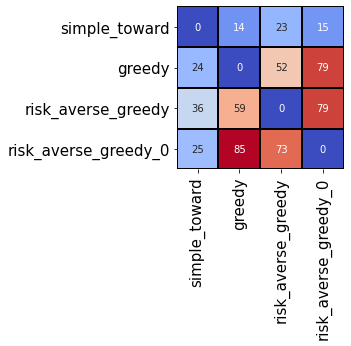

In [85]:
df_scores = pd.DataFrame(
    scores, 
    index=list_names, 
    columns=list_names,
)


plt.figure(figsize=(3, 3))
sn.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap='coolwarm', linewidths=1, 
    linecolor='black', fmt="d",
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=15);

